## Download COCO Dataset

In [0]:
%%bash
pip install Cython
git clone https://github.com/waleedka/coco
pip install -U setuptools
pip install -U wheel
make install -C coco/PythonAPI

  Found existing installation: setuptools 46.3.0
    Uninstalling setuptools-46.3.0:
      Successfully uninstalled setuptools-46.3.0
Requirement already up-to-date: wheel in /usr/local/lib/python3.6/dist-packages (0.34.2)
make: Entering directory '/content/coco/PythonAPI'
# install pycocotools to the Python site-packages
python setup.py build_ext install
Compiling pycocotools/_mask.pyx because it changed.
[1/1] Cythonizing pycocotools/_mask.pyx
running build_ext
building 'pycocotools._mask' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
creating build/common
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I../common -I/usr/include/python3.6m -c pycocotools/_mask.c -o build/temp.linux-x86_64-3.6/pycocotools/_mask.o -Wno-cpp -Wno-unused-function -std=c99


Cloning into 'coco'...
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
../common/maskApi.c: In function ‘rleDecode’:
../common/maskApi.c:46:7: warning: this ‘for’ clause does not guard... [-Wmisleading-indentation]
       for( k=0; k<R[i].cnts[j]; k++ ) *(M++)=v; v=!v; }}
       ^~~
../common/maskApi.c:46:49: note: ...this statement, but the latter is misleadingly indented as if it were guarded by the ‘for’
       for( k=0; k<R[i].cnts[j]; k++ ) *(M++)=v; v=!v; }}
                                                 ^
../common/maskApi.c: In function ‘rleFrPoly’:
../common/maskApi.c:165:3: warning: this ‘for’ clause does not guard... [-Wmisleading-indentation]
   for(j=0; j<k; j++) x[j]=(int)(scale*xy[j*2+0]+.5); x[k]=x[0];
   ^~~
../common/maskApi.c:165:54: note: ...this statement, but the latter is misleadingly indented as if it were guarded by the ‘for’
   for(j=0; j<k; j++) x[j]=(int)(scale*xy[j*2+0]+.5); x[k]=x[0];
         

In [0]:
%%bash
mkdir data
wget http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip -P ./data/
wget http://images.cocodataset.org/zips/train2014.zip -P ./data/
wget http://images.cocodataset.org/zips/val2014.zip -P ./data/

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
%%bash
unzip ./data/captions_train-val2014.zip -d ./data/
rm ./data/captions_train-val2014.zip
unzip ./data/val2014.zip -d ./data/ 
rm ./data/val2014.zip
unzip ./data/train2014.zip -d ./data/
rm ./data/train2014.zip 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Tensorflow Version

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import sys
import os

## Hyper Parameters

### General Parameters

In [0]:
TRAIN_CAPTION_PATH = "/content/data/annotations/captions_train2014.json"    # caption for training data
TEST_CAPTION_PATH = "/content/data/annotations/captions_val2014.json"       # caption for training data
TRAIN_IMAGE_PATH = "/content/data/train2014/"                               # training images
TEST_IMAGE_PATH = "/content/data/val2014/"                                  # validation images
MODEL_PATH = "/content/data/"                                               # path to save model
MIN_THRESHOLD = 4                                                           # minimum ocurrence to add a word to vocabulary
PAD, UNK, START, END = '<pad>', '<unk>', '<start>', '<end>'                 # special tokens
PAD_ID = None                                                               # the ID for PAD, need this when we create the data loader
VOCAB_LEN = None                                                            # number of items in vocabulary
                                                                            # we will determine PAD_ID and VOCAB_LEN once we build vocab

### Model Parameters

In [0]:
from keras.applications import InceptionV3
from keras.optimizers import RMSprop
from keras import backend as K

NUM_EPOCHS = 40
BATCH_SIZE = 256
BACKBONE = InceptionV3(include_top=True, weights='imagenet')
OPTIMIZER = RMSprop(lr=1e-3)

EMBED_SIZE = 256                                    # dimension of word embedding vectors
HIDDEN_SIZE = 512                                   # dimention of lstm hidden states
NUM_LAYERS = 3                                      # number of layers in lstm
MAX_LENGTH = 30                                     # the max length for prediction captions
IMAGE_SIZE = K.int_shape(BACKBONE.input)[1:3]        # input size of encoder
TRANSFER_LAYER = BACKBONE.layers[-2]                # the last but one layer in the encoder
OUTPUT_SIZE = K.int_shape(TRANSFER_LAYER.output)[1] # output size of encoder

Using TensorFlow backend.


96116736/96112376 [==============================] - 3s 0us/step


## Load and Show Images

In [0]:
from pycocotools.coco import COCO
def load_records(train=True):
    if train:
        coco = COCO(TRAIN_CAPTION_PATH)
    else:
        coco = COCO(TEST_CAPTION_PATH)

    ids = coco.anns.keys()
    image2captions = {}

    for id in ids:
        image_id = coco.anns[id]['image_id']
        image_name = coco.loadImgs(image_id)[0]['file_name']
        
        if image_name in image2captions:
            image2captions[image_name].append(coco.anns[id]['caption'])
        else:
            image2captions[image_name] = [coco.anns[id]['caption']]

    print(f"Total images: {len(image2captions)}, total captions: {len(ids)}")

    filenames = []
    captions  = []
    for key in image2captions:
        filenames.append(key)
        captions.append(image2captions[key])
    
    return filenames, captions

In [0]:
filenames_train, captions_train = load_records(train=True)

loading annotations into memory...
Done (t=2.43s)
creating index...
index created!
Total images: 82783, total captions: 414113


In [0]:
filenames_test, captions_test = load_records(train=False)

loading annotations into memory...
Done (t=1.11s)
creating index...
index created!
Total images: 40504, total captions: 202654


In [0]:
def random_image(idx=None, train=True):
    if train:
        dir = TRAIN_IMAGE_PATH
        filenames, captions = filenames_train, captions_train
    else:
        dir = TEST_IMAGE_PATH
        filenames, captions = filenames_test, captions_test

    if idx is None:
        idx = np.random.randint(len(filenames))
    
    filename = filenames[idx]
    caption = captions[idx]
    path = os.path.join(dir, filename)
    return path, caption    

In [0]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """

    # Load the image using PIL.
    img = Image.open(path)

    # Resize image if desired.
    if size is not None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    # Convert image to numpy array.
    img = np.array(img)

    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

In [0]:
def show_image(idx=None, train=True):
    """
    Load and plot an image from the training- or validation-set
    with the given index.
    """

    path, caption = random_image(idx, train)

    # Print the captions for this image.
    for c in caption:
        print(c)
    
    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()

These two people are riding their bikes in the street. 
Group of people riding their bicycles on a city street. 
A couple of people riding bikes down a street.
a couple are riding their bikes down a street
Two people riding bicycles down the street during the day.


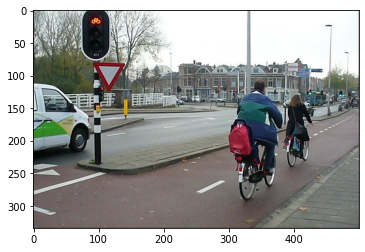

In [0]:
show_image()

## Preprocess Images

In [0]:
import math
import pickle
from tqdm.autonotebook import tqdm
from keras.models import Model

encoder = Model(inputs=BACKBONE.input, outputs=TRANSFER_LAYER.output)
print(f"Encoder input size: {IMAGE_SIZE}, output size: {OUTPUT_SIZE}")
num_total = len(filenames_train)
encoder_out = np.zeros(shape=(num_total, OUTPUT_SIZE), dtype=np.float32)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  This is separate from the ipykernel package so we can avoid doing imports until


Encoder input size: (299, 299), output size: 2048


In [0]:
if os.path.exists('encoder_out.pkl'):
    with open('encoder_out.pkl','rb') as f: 
        encoder_out = pickle.load(f)
else:
    # manually design a batch generator
    starts = range(0,num_total,BATCH_SIZE)
    progress = tqdm(starts, total=len(starts))
    for beg in progress:
        encoder_in = np.zeros(shape=(BATCH_SIZE,)+IMAGE_SIZE+(3,), dtype=np.float32)
        end = min(beg+BATCH_SIZE, num_total)

        for i, filename in enumerate(filenames_train[beg:end]):
            path = os.path.join(TRAIN_IMAGE_PATH, filename)
            image = load_image(path, size=IMAGE_SIZE)
            encoder_in[i] = image

        encoder_out[beg:end] = encoder.predict(encoder_in)[:end-beg]

In [0]:
print("dtype:", encoder_out.dtype)
print("shape:", encoder_out.shape)

dtype: float32
shape: (82783, 2048)


In [0]:
if not os.path.exists('encoder_out.pkl'):
    with open('encoder_out.pkl','wb') as f: 
        pickle.dump(encoder_out, f)

## Build Vocabulary and Tokenizer

In [0]:
class Vocabulary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [0]:
import nltk
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer
from collections import Counter

coco = COCO(TRAIN_CAPTION_PATH)
counter = Counter()
ids = coco.anns.keys()

progress = tqdm(captions_train, total=len(captions_train))
regexp = RegexpTokenizer(r'\w+') # we don't want to tokenlize punctuation
for captions in progress:
    for caption in captions:
        tokens = regexp.tokenize(caption.lower())
        counter.update(tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
loading annotations into memory...
Done (t=2.46s)
creating index...
index created!


In [0]:
words = [PAD, UNK, START, END] + [word for word, cnt in counter.items() if cnt >= MIN_THRESHOLD]
vocab = Vocabulary()

# Add words to the vocabulary.
for i, word in enumerate(words):
    vocab.add_word(word)

PAD_ID = vocab(PAD)
VOCAB_LEN = len(vocab)
print(f"Totoal Vocabulary: {VOCAB_LEN}, PAD_ID is {PAD_ID}")

Totoal Vocabulary: 9819, PAD_ID is 0


In [0]:
class Tokenizer(object):
    def __init__(self, vocab):
        self.vocab = vocab

    def sentence2index(self, sentence: str) -> [int]:
        tokens = [START] + regexp.tokenize(sentence.lower()) + [END]
        return [self.vocab(token) for token in tokens]

    def captions2index(self, captions: [[str]]) -> [[[int]]]:
        return [[self.sentence2index(sentence) for sentence in caption] for caption in captions]

    def index2sentence(self, index: [int]) -> str:
        return " ".join([self.vocab.idx2word[i] for i in index])

In [0]:
tokenizer = Tokenizer(vocab=vocab)

In [0]:
%%time
tokens_train = tokenizer.captions2index(captions_train)

CPU times: user 4.32 s, sys: 64.4 ms, total: 4.38 s
Wall time: 4.39 s


In [0]:
tokens_train[0]

[[2, 4, 5, 6, 7, 8, 9, 10, 11, 3],
 [2, 4, 12, 7, 13, 11, 14, 15, 16, 17, 18, 3],
 [2, 4, 11, 14, 4, 19, 20, 21, 7, 12, 22, 23, 24, 25, 26, 27, 3],
 [2, 28, 29, 30, 20, 4, 31, 9, 11, 3],
 [2, 4, 32, 33, 1, 34, 14, 24, 17, 35, 34, 4, 11, 3]]

In [0]:
captions_train[0]

['A very clean and well decorated empty bathroom',
 'A blue and white bathroom with butterfly themed wall tiles.',
 'A bathroom with a border of butterflies and blue paint on the walls above it.',
 'An angled view of a beautifully decorated bathroom.',
 'A clock that blends in with the wall hangs in a bathroom. ']

In [0]:
# save the vocab and load it in the App
import json
with open('idx2word.json', 'w') as f:
    json.dump(vocab.idx2word, f)

## Build Data Generator

In [0]:
def get_random_caption_tokens(idx):
    """
    Given a list of indices for images in the training-set,
    select a token-sequence for a random caption,
    and return a list of all these token-sequences.
    """
    result = []
    for i in idx:
        # Get a random index for a token-sequence.
        j = np.random.choice(len(tokens_train[i]))
        tokens = tokens_train[i][j]
        result.append(tokens)
    return result

In [0]:
from keras.preprocessing.sequence import pad_sequences
def batch_generator(batch_size):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        idx = np.random.randint(num_total, size=batch_size)
        # this will be the initial values for our RNN
        init_values = encoder_out[idx]
        tokens = get_random_caption_tokens(idx)

        # Max number of tokens.
        max_tokens = np.max([len(t) for t in tokens])
        
        # Pad the token-sequences with PAD_ID
        tokens_padded = pad_sequences(tokens, maxlen=max_tokens, padding='post', truncating='post', value=PAD_ID)
        
        # we always feed in correct words for the following cells
        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, 1:]

        # Dict for the input-data.
        x_data = { 'decoder_input': decoder_input_data, 'init_values': init_values }

        # Dict for the output-data.
        y_data = { 'decoder_output': decoder_output_data[:,:,np.newaxis] }
        
        yield (x_data, y_data)

In [0]:
generator = batch_generator(batch_size=BATCH_SIZE)
total_captions = np.sum([len(captions) for captions in captions_train])
steps_per_epoch = int(total_captions / BATCH_SIZE)
print(f"There are {total_captions} captions in total and we will run {steps_per_epoch} steps per epoch.")

There are 414113 captions in total and we will run 1617 steps per epoch.


In [0]:
batch = next(generator)
batch_x = batch[0]
batch_y = batch[1]

In [0]:
batch_y['decoder_output'][0]

array([[  4],
       [191],
       [420],
       [  4],
       [299],
       [723],
       [  7],
       [110],
       [502],
       [  3],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0]], dtype=int32)

## Build Decoder Model





In [0]:
from keras.layers import Input, Dense, GRU, Embedding
def define_decoder():
    # inputs
    init_values = Input(shape=(OUTPUT_SIZE,), name='init_values')
    decoder_input = Input(shape=(None, ), name='decoder_input')

    # convert encoder output to correct size
    init_state = Dense(HIDDEN_SIZE, activation='tanh', name='decoder_transfer_map')(init_values)
    # convert tokens input to embeddings
    rnn_input = Embedding(input_dim=VOCAB_LEN, output_dim=EMBED_SIZE, name='decoder_embedding')(decoder_input)
    # multi layer RNN
    for i in range(NUM_LAYERS):
        rnn_input = GRU(HIDDEN_SIZE, name=f'decoder_gru{i+1}', return_sequences=True)(rnn_input, initial_state=init_state)
    # convert to one hot arrays
    decoder_output = Dense(VOCAB_LEN, activation='softmax', name='decoder_output')(rnn_input)

    decoder = Model(inputs=[init_values, decoder_input], outputs=[decoder_output])
    decoder.compile(optimizer=OPTIMIZER, loss='sparse_categorical_crossentropy')
    decoder.summary()

    return decoder

In [0]:
decoder = define_decoder()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
init_values (InputLayer)        (None, 2048)         0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, None, 256)    2513664     decoder_input[0][0]              
__________________________________________________________________________________________________
decoder_transfer_map (Dense)    (None, 512)          1049088     init_values[0][0]                
____________________________________________________________________________________________

## Train Model

In [0]:
%%time
decoder.fit(x=generator, steps_per_epoch=steps_per_epoch, epochs=NUM_EPOCHS)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/40
1617/1617 [==============================] - 535s 331ms/step - loss: 1.5214
Epoch 2/40
1617/1617 [==============================] - 528s 326ms/step - loss: 1.1744
Epoch 3/40
1617/1617 [==============================] - 523s 324ms/step - loss: 1.1195
Epoch 4/40
1617/1617 [==============================] - 525s 325ms/step - loss: 1.0825
Epoch 5/40
1617/1617 [==============================] - 524s 324ms/step - loss: 1.0567
Epoch 6/40
1617/1617 [==============================] - 527s 326ms/step - loss: 1.0300
Epoch 7/40
1617/1617 [==============================] - 523s 324ms/step - loss: 1.0159
Epoch 8/40
1617/1617 [==============================] - 527s 326ms/step - loss: 0.9914
Epoch 9/40
1617/1617 [==============================] - 517s 320ms/step - loss: 0.9891
Epoch 10/40
1617/1617 [==============================] - 521s 322ms/step - loss: 0.9684
Epoch 11/40
1617/1617 [==============================] - 528s 327ms/step - loss: 0.9422
Epoch 12/40
1617/1617 [==================

In [0]:
# save model
encoder.save('encoder.h5')
decoder.save('decoder.h5')

## Test Model

In [0]:
if os.path.exists('encoder.h5'):
    encoder.load_weights('encoder.h5')
if os.path.exists('decoder.h5'):
    decoder.load_weights('decoder.h5')

In [0]:
def generate_caption(image_path=None, idx=None, max_tokens=MAX_LENGTH):
    """
    Generate a caption for the image in the given path or given index
    The caption is limited to the given number of tokens (words).
    """

    if image_path is None:
        image_path, _ = random_image(idx=idx, train=False)

    # Load and resize the image.
    image = load_image(image_path, size=IMAGE_SIZE)
    
    # Expand the 3-dim numpy array to 4-dim
    image_batch = np.expand_dims(image, axis=0)

    # Process the image with the pre-trained CNN to get initial values for RNN
    init_values = encoder.predict(image_batch)
    # tmp = init_values[0]
    input_seq = [[vocab(START)]]
    output_text = []

    # Note that in Keras, we don't have good support for previous output as current input
    # so we will concatenate the output to input_seq and run the model for each iteration
    # this is not very efficient but easy to understand
    for _ in range(max_tokens):
        if input_seq[0][-1] == vocab(END):
            break

        # Wrap the input-data in a dict for clarity and safety
        x_data = \
        {
            'init_values': init_values,
            'decoder_input': np.array(input_seq)
        }
        decoder_output = decoder.predict(x_data)

        # get the last output and convert to integer token
        token_onehot = decoder_output[0][-1]

        # if len(input_seq[0]) == 1:
        #     tmp = token_onehot

        token_int = np.argmax(token_onehot)

        # add lastest output to input_seq and convert it to word
        input_seq[0].append(token_int)
        sampled_word = vocab.idx2word[token_int]
        output_text.append(sampled_word)

    # Plot the image.
    plt.imshow(image)
    plt.show()
    
    # Print the predicted caption.
    print("Predicted caption:")
    print(" ".join(output_text))
    print()
    # return tmp

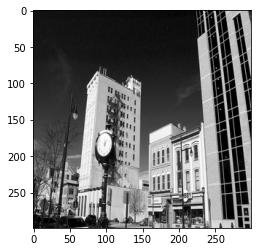

Predicted caption:
a clock on a building with a sky background <end>



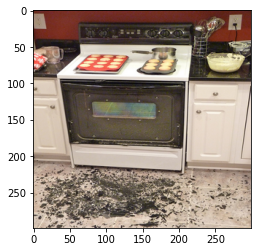

Predicted caption:
an oven with a pizza in it in the kitchen <end>



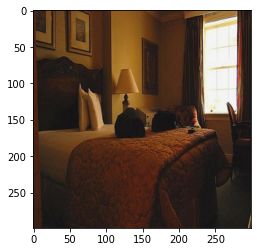

Predicted caption:
a bed sitting next to a window with a large bed and a window <end>



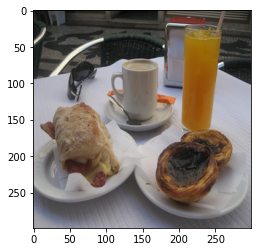

Predicted caption:
a couple of plates of food on a table <end>



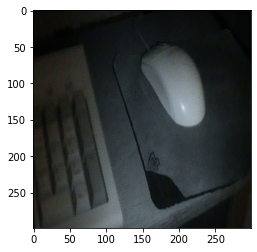

Predicted caption:
a computer mouse and keyboard sit on a table <end>



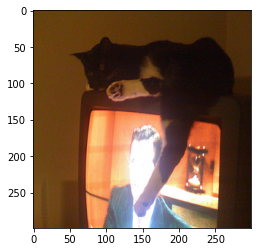

Predicted caption:
a cat sitting on top of a tv <end>



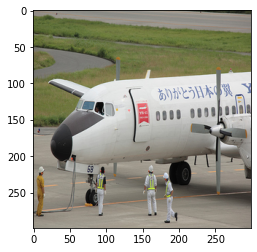

Predicted caption:
a large white jetliner sitting on top of an airport runway <end>



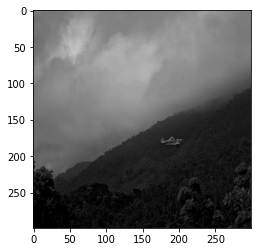

Predicted caption:
a person on a horse riding down a hill <end>



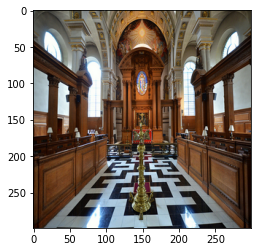

Predicted caption:
a large cathedral with a bed and many windows <end>



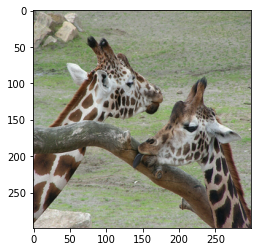

Predicted caption:
a giraffe is standing in a grassy field <end>



In [0]:
for _ in range(10):
    generate_caption()

## Convert Model

In [0]:
# we need to decompose decoder into two parts because coremltools doesn't support initial_state
from keras.layers import Input, Dense, GRU, LSTM, Embedding
def define_map():
    init_values = Input(shape=(OUTPUT_SIZE,), name='init_values')
    # convert encoder output to correct size
    init_state = Dense(HIDDEN_SIZE, activation='tanh', name='decoder_transfer_map')(init_values)
    
    transfer_map = Model(inputs=[init_values], outputs=[init_state])
    # transfer_map.compile(optimizer=OPTIMIZER, loss='sparse_categorical_crossentropy')
    transfer_map.summary()
    return transfer_map

def define_gru():
    decoder_input = Input(shape=(None, ), name='decoder_input')
    # convert tokens input to embeddings
    rnn_input = Embedding(input_dim=VOCAB_LEN, output_dim=EMBED_SIZE, name='decoder_embedding')(decoder_input)
    # multi layer RNN
    for i in range(NUM_LAYERS):
        rnn_input = GRU(HIDDEN_SIZE, name=f'decoder_gru{i+1}', return_sequences=True)(rnn_input)
    # convert to one hot arrays
    decoder_output = Dense(VOCAB_LEN, activation='softmax', name='decoder_output')(rnn_input)

    gru = Model(inputs=[decoder_input], outputs=[decoder_output])
    # gru.compile(optimizer=OPTIMIZER, loss='sparse_categorical_crossentropy')
    gru.summary()

    return gru

In [0]:
transfer_map = define_map()
gru = define_gru()
transfer_map.load_weights('decoder.h5', by_name=True)
gru.load_weights('decoder.h5', by_name=True)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
init_values (InputLayer)     (None, 2048)              0         
_________________________________________________________________
decoder_transfer_map (Dense) (None, 512)               1049088   
Total params: 1,049,088
Trainable params: 1,049,088
Non-trainable params: 0
_________________________________________________________________
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, None)              0         
_________________________________________________________________
decoder_embedding (Embedding (None, None, 256)         2513664   
_________________________________________________________________
decoder_gru1 (GRU)           (None, None, 512)         1181184   
________________________________

In [0]:
!pip install coremltools
import coremltools
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

     |████████████████████████████████| 3.4MB 5.1MB/s 


In [0]:
coreml_encoder = coremltools.converters.keras.convert(encoder, input_names=["image"], image_input_names="image", image_scale=1./255, output_names=["output"])
coreml_map = coremltools.converters.keras.convert(transfer_map, input_names=["encoder_out"], output_names=["init_states"])
coreml_gru = coremltools.converters.keras.convert(gru, input_names=["decoder_input"], output_names=["decoder_output"])

0 : input_1, <keras.engine.input_layer.InputLayer object at 0x7fc5af951f60>
1 : conv2d_1, <keras.layers.convolutional.Conv2D object at 0x7fc56c5ecc18>
2 : batch_normalization_1, <keras.layers.normalization.BatchNormalization object at 0x7fc56c5ecdd8>
3 : activation_1, <keras.layers.core.Activation object at 0x7fc56c5ecef0>
4 : conv2d_2, <keras.layers.convolutional.Conv2D object at 0x7fc5cc2c14a8>
5 : batch_normalization_2, <keras.layers.normalization.BatchNormalization object at 0x7fc56bdd0668>
6 : activation_2, <keras.layers.core.Activation object at 0x7fc56bdd0f60>
7 : conv2d_3, <keras.layers.convolutional.Conv2D object at 0x7fc56023d9e8>
8 : batch_normalization_3, <keras.layers.normalization.BatchNormalization object at 0x7fc5601d7828>
9 : activation_3, <keras.layers.core.Activation object at 0x7fc5601d7240>
10 : max_pooling2d_1, <keras.layers.pooling.MaxPooling2D object at 0x7fc56023de48>
11 : conv2d_4, <keras.layers.convolutional.Conv2D object at 0x7fc5601ef198>
12 : batch_normali

In [0]:
print("="*10+" coreml_encoder "+"="*10)
print(coreml_encoder)
print()
print("="*10+" coreml_map "+"="*10)
print(coreml_map)
print()
print("="*10+" coreml_gru "+"="*10)
print(coreml_gru)

========== coreml_encoder ==========
input {
  name: "image"
  type {
    imageType {
      width: 299
      height: 299
      colorSpace: RGB
    }
  }
}
output {
  name: "output"
  type {
    multiArrayType {
      shape: 2048
      dataType: DOUBLE
    }
  }
}
metadata {
  userDefined {
    key: "coremltoolsVersion"
    value: "3.4"
  }
}


========== coreml_map ==========
input {
  name: "encoder_out"
  type {
    multiArrayType {
      shape: 2048
      dataType: DOUBLE
    }
  }
}
output {
  name: "init_states"
  type {
    multiArrayType {
      shape: 512
      dataType: DOUBLE
    }
  }
}
metadata {
  userDefined {
    key: "coremltoolsVersion"
    value: "3.4"
  }
}


========== coreml_gru ==========
input {
  name: "decoder_input"
  type {
    multiArrayType {
      shape: 1
      dataType: DOUBLE
    }
  }
}
input {
  name: "decoder_gru1_h_in"
  type {
    multiArrayType {
      shape: 512
      dataType: DOUBLE
    }
    isOptional: true
  }
}
input {
  name: "decoder_gru2

In [0]:
coreml_encoder.save("encoder.mlmodel")
coreml_map.save("map.mlmodel")
coreml_gru.save("gru.mlmodel")


# Pytorch Version

## Hyper Parameters

In [0]:
import torchvision.models as models
# General Parameters
TRAIN_CAPTION_PATH = "/content/data/annotations/captions_train2014.json"    # caption for training data
TEST_CAPTION_PATH = "/content/data/annotations/captions_val2014.json"       # caption for training data
TRAIN_IMAGE_PATH = "/content/data/train2014/"                               # training images
TEST_IMAGE_PATH = "/content/data/val2014/"                                  # validation images
VOCAB_PATH = "/content/data/vocab.pkl"                                      # path to save vocabulary
MODEL_PATH = "/content/data/"                                               # path to save model
MIN_THRESHOLD = 4                                                           # minimum ocurrence to add a word to vocabulary
PAD, UNK, START, END = '<pad>', '<unk>', '<start>', '<end>'                 # special tokens
PAD_ID = None                                                               # the ID for PAD, need this when we create the data loader
VOCAB_LEN = None                                                            # number of items in vocabulary
                                                                            # we will determine PAD_ID and VOCAB_LEN once we build vocab

# Model Parameters
NUM_EPOCHS = 3
BATCH_SIZE = 128
LEARNING_RATE = 0.001
BACKBONE = models.resnet50(pretrained=True)
EMBED_SIZE = 256                                # dimension of word embedding vectors
HIDDEN_SIZE = 512                               # dimention of lstm hidden states
NUM_LAYERS = 1                                  # number of layers in lstm
MAX_LENGTH = 30                                 # the max length for prediction captions

## Build Vocabulary

In [0]:
import nltk
nltk.download('punkt')
import pickle
from pycocotools.coco import COCO
from collections import Counter
from tqdm.autonotebook import tqdm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
class Vocabulary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [0]:
coco = COCO(CAPTION_PATH)
counter = Counter()
ids = coco.anns.keys()

progress = tqdm(enumerate(ids), total=len(ids))
for i, id in progress:
    caption = str(coco.anns[id]['caption'])
    tokens = nltk.tokenize.word_tokenize(caption.lower())
    counter.update(tokens)

loading annotations into memory...
Done (t=1.32s)
creating index...
index created!


In [0]:
coco.anns[42]

{'caption': 'Three zebras eating hay from bales inside a barn-like structure.\n',
 'id': 42,
 'image_id': 466265}

In [0]:
words = [PAD, UNK, START, END] + [word for word, cnt in counter.items() if cnt >= MIN_THRESHOLD]
vocab = Vocabulary()

# Add words to the vocabulary.
for i, word in enumerate(words):
    vocab.add_word(word)

PAD_ID = vocab(PAD)
VOCAB_LEN = len(vocab)
print(f"Totoal Vocabulary: {VOCAB_LEN}, PAD_ID is {PAD_ID}")

Totoal Vocabulary: 9956, PAD_ID is 0


In [0]:
# save vocabulary
with open(VOCAB_PATH, 'wb') as f:
    pickle.dump(vocab, f)

## Build Dataset and Dataloader

In [0]:
import torch
import torch.utils.data as data
import os
from pycocotools.coco import COCO
from PIL import Image
import nltk

class CocoDataset(data.Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, vocab=None, transform=None, train=True):
        """Set the path for images, captions and vocabulary wrapper.
        
        Args:
            vocab: vocabulary wrapper.
            transform: image transformer.
        """

        self.train = train
        if self.train:
            self.coco = COCO(TRAIN_CAPTION_PATH)
        else:
            self.coco = COCO(TEST_CAPTION_PATH)
        self.vocab = vocab
        self.ids = list(self.coco.anns.keys())
        self.transform = transform

    def __getitem__(self, index):
        """Returns one data pair (image and caption)."""
        ann_id = self.ids[index]
        coco = self.coco
        vocab = self.vocab
        img_id = coco.anns[ann_id]['image_id']
        image_name = coco.loadImgs(img_id)[0]['file_name']
        caption = coco.anns[ann_id]['caption']

        if self.train:
            image = Image.open(TRAIN_IMAGE_PATH + image_name).convert('RGB')
        else:
            image = Image.open(TEST_IMAGE_PATH + image_name).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        if self.train:
            # Convert caption (string) to word ids.
            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = []
            caption.append(vocab('<start>'))
            caption.extend([vocab(token) for token in tokens])
            caption.append(vocab('<end>'))
            target = torch.Tensor(caption)
            return image, target
        else:
            return image, image_name

    def __len__(self):
        return len(self.ids)

In [0]:
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.Resize((256,256)),
     transforms.RandomCrop(224,224),
     transforms.RandomHorizontalFlip(), 
     transforms.ToTensor(), 
     transforms.Normalize((0.485, 0.456, 0.406), 
                          (0.229, 0.224, 0.225))])

In [0]:
# COCO caption dataset
coco = CocoDataset(vocab=vocab, transform=transform)

loading annotations into memory...
Done (t=0.67s)
creating index...
index created!


In [0]:
def collate_fn(data):
    """Creates mini-batch tensors from the list of tuples (image, caption).
    
    We should build custom collate_fn rather than using default collate_fn, 
    because merging caption (including padding) is not supported in default.

    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.

    Returns:
        images: torch tensor of shape (BATCH_SIZE, 3, 256, 256).
        targets: torch tensor of shape (BATCH_SIZE, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # We need a sorted caption for pack_padded_sequence
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # 1. Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # 2. Merge captions (from tuple of 1D tensor to 2D tensor).
    # Note that lengths should be sorted in decreasing order
    lengths = [len(cap) for cap in captions]
    # We need to fill the targets with PAD_ID
    targets = torch.Tensor(len(captions), lengths[0]).long()
    targets.fill_(PAD_ID)
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

In [0]:
# Data loader for COCO dataset
# This will return (images, captions, lengths) for each iteration.
data_loader = torch.utils.data.DataLoader(dataset=coco, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=collate_fn)

## Build Encoder and Decoder

In [0]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence

class EncoderCNN(nn.Module):
    def __init__(self):
        """Load the pretrained CNN and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        # delete the last fc layer
        modules = list(BACKBONE.children())[:-1]
        self.cnn = nn.Sequential(*modules)
        self.linear = nn.Linear(BACKBONE.fc.in_features, EMBED_SIZE)
        self.bn = nn.BatchNorm1d(EMBED_SIZE, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        # we won't further train the CNN model
        with torch.no_grad():
            features = self.cnn(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, vocab_size=len(vocab)):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, EMBED_SIZE)
        self.lstm = nn.LSTM(EMBED_SIZE, HIDDEN_SIZE, NUM_LAYERS, batch_first=True)
        self.linear = nn.Linear(HIDDEN_SIZE, vocab_size)
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        # we will feed in image features for the first cell
        # and always feed in correct words for the following cells
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(MAX_LENGTH):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (BATCH_SIZE, 1, HIDDEN_SIZE)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (BATCH_SIZE, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (BATCH_SIZE)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (BATCH_SIZE, EMBED_SIZE)
            inputs = inputs.unsqueeze(1)                         # inputs: (BATCH_SIZE, 1, EMBED_SIZE)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (BATCH_SIZE, MAX_LENGTH)
        return sampled_ids

## Build Model

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
# Build the models
encoder = EncoderCNN().to(device)
decoder = DecoderRNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
# Note: we won't further train the CNN model so we only include linear and bn parameters
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())     
optimizer = torch.optim.Adam(params, lr=LEARNING_RATE)

In [0]:
print(encoder)

EncoderCNN(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 2

In [0]:
print(decoder)

DecoderRNN(
  (embed): Embedding(9956, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=9956, bias=True)
)


## Train Model


In [0]:
loss_history = []
for epoch in range(NUM_EPOCHS):
    progress = tqdm(enumerate(data_loader), desc="Loss: ", total=len(data_loader))
    for i, (images, captions, lengths) in progress:
        
        # Set mini-batch dataset
        images = images.to(device)
        captions = captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
        
        # Forward, backward and optimize
        features = encoder(images)
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs, targets)
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()

        # updating progress bar
        loss_history.append(loss.item())
        progress.set_description("Loss: {:.4f}".format(loss_history[-1]))

    # Save the model checkpoints
    torch.save(decoder.state_dict(), MODEL_PATH + f"decoder{epoch+1}.ckpt")
    torch.save(encoder.state_dict(), MODEL_PATH + f"encoder{epoch+1}.ckpt")

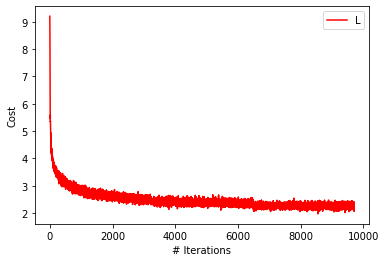

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
# Plot cost 
plt.plot(loss_history, 'r')
plt.xlabel('# Iterations')
plt.ylabel('Cost')
plt.legend('Loss', loc='upper right')
plt.show()

In [0]:
# try to further training with smaller learning rate
optimizer = torch.optim.Adam(params, lr=LEARNING_RATE/2)
loss_history = []
for epoch in range(NUM_EPOCHS, NUM_EPOCHS*2):
    progress = tqdm(enumerate(data_loader), desc="Loss: ", total=len(data_loader))
    for i, (images, captions, lengths) in progress:
        
        # Set mini-batch dataset
        images = images.to(device)
        captions = captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
        
        # Forward, backward and optimize
        features = encoder(images)
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs, targets)
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()

        # updating progress bar
        loss_history.append(loss.item())
        progress.set_description("Loss: {:.4f}".format(loss_history[-1]))

    # Save the model checkpoints
    torch.save(decoder.state_dict(), MODEL_PATH + f"decoder{epoch+1}.ckpt")
    torch.save(encoder.state_dict(), MODEL_PATH + f"encoder{epoch+1}.ckpt")

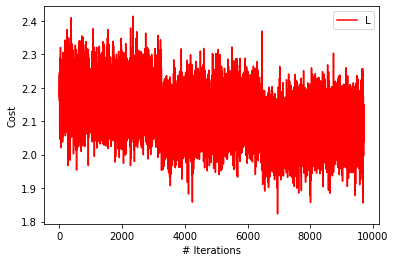

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
# Plot cost 
plt.plot(loss_history, 'r')
plt.xlabel('# Iterations')
plt.ylabel('Cost')
plt.legend('Loss', loc='upper right')
plt.show()

## Test Model

In [0]:
# COCO caption dataset
coco_test = CocoDataset(vocab=vocab, transform=transform, train=False)

loading annotations into memory...
Done (t=1.17s)
creating index...
index created!


<start> a cat is sitting on a laptop keyboard . <end>


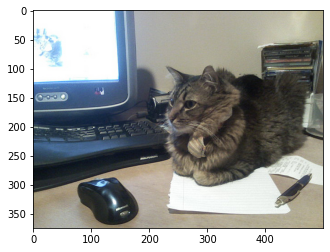

In [0]:
import numpy as np
encoder_test = EncoderCNN().eval()  # eval mode (batchnorm uses moving mean/variance)
encoder_test = encoder_test.to(device)

decoder_test = DecoderRNN()
decoder_test = decoder_test.to(device)

# Load the trained model parameters
encoder_test.load_state_dict(torch.load(MODEL_PATH + f"encoder{NUM_EPOCHS*2}.ckpt"))
decoder_test.load_state_dict(torch.load(MODEL_PATH + f"decoder{NUM_EPOCHS*2}.ckpt"))

# Prepare an image
ind = np.random.randint(len(coco_test))
image, image_name = coco_test[ind]
image_tensor = image.unsqueeze(0).to(device)

# Generate an caption from the image
feature = encoder_test(image_tensor)
sampled_ids = decoder_test.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)

# Convert word_ids to words
sampled_caption = []
for word_id in sampled_ids:
    word = vocab.idx2word[word_id]
    sampled_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(sampled_caption)

# Print out the image and the generated caption
print (sentence)
image = Image.open(TEST_IMAGE_PATH+image_name)
plt.imshow(np.asarray(image))

## Convert Model

FAILED. Pytorch don't support RNN conversion :(